In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### Introduction

Consider a scenario where we need to track motion of a robot. In an ideal case, we can find the position of robot using equations governing Newton's Laws of Motion. However, in reality, there will always be a noise (For example - air drag, friction from surface) which will make our calculated estimates uncertain. At the same time, assume that there is a sensor that is attached to robot which also measures the movement of robot. In this case as well, the estimates are going to be noisy due to factors like worn-out machinery, friction in it.

Basically, we have two ways to estimate position of robot. However, these estimates are somewhat imperfect (we don't expect the world to be an ideal environment). So, is there a way that we can combine these two esimates to get an estimate which is less noisy and better than either of the two. Kalman Filters do that for you.

### Applications of Kalman Filter

Kalman Filters are widely used in the area of Object Tracking in Artificial Intelligence systems. For example - Self-Driving Cars. Take a case where a person who was visible for a number of frames gets occluded by a car later. Now when the person is occluded, since there aren't pixels occupied by the person, it's impossible for Detector to detect the person. 

However, using Kalman Filter, knowing that the person was moving from certain position in a certain direction (measurements), the Kalman Filter will be able to predict the trajectory, and so it's possible to track the person even if the Detector can't.

### Assumptions

Some of the assumptions of basic Kalman Filter are:
1. Linear motion model with Gaussian Noise $\mathbf{x}_{t}=A \mathbf{x}_{t-1}+B \mathbf{u}_{t-1}+\mathbf{w}_{t}$, where $\mathbf{w}_{t} \sim \mathscr{N}(0, Q)$

2. Linear measurement model with Gaussian Noise $\mathbf{z}_{t}=H \mathbf{x}_{t}+\mathbf{n}_{t}$, where $\mathbf{n}_{t} \sim \mathscr{N}(0, R)$

3. Gaussian prior for initial state $\mathbf{x}_{0} \sim \mathscr{N}\left(\mu_{0}, \Sigma_{0}\right)$

### Limitations

Some of the limitations of Kalman Filter stem from the assumptions it considers:
1. A constant velocity model might not be appropriate to simulate all kinds of motions
2. Gaussian distribution as prior might not be the correct choice 

However, there are filters such as Extended Kalman Filter (EKF), Particle Filter which take care of such issues and can model complex states.

#### Simulating ground truth motion

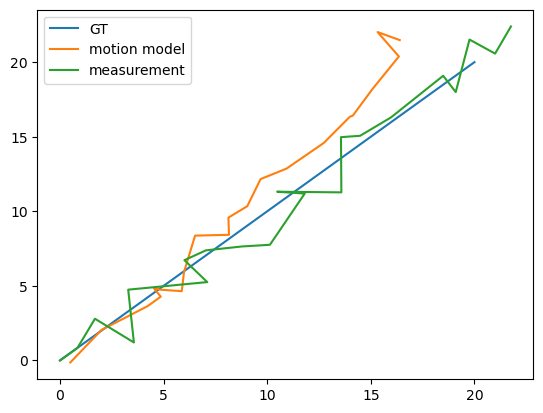

In [2]:
# initialize variables
num_steps = 20
motion_noise_mean = np.array([0, 0])
measurement_mean = np.array([0, 0])
initial_pos_belief_mean = np.array([0, 0])
initial_pos_belief_covariance = np.array([[1, 0],[0, 1]])
motion_vel = np.array([1 ,1])

A = np.array([[1, 0], [0, 1]])
B = np.array([[1, 0], [0, 1]])
H = np.array([[1.1, 0], [0, 1.1]])
Q = np.array([[0.6, 0], [0, 0.6]])
R = np.array([[1.2, 0], [0, 1.2]])

# seeding
seed = 42
np.random.seed(seed)

# ground truth motion
# moving along Y = X axis starting from origin with constant velocity
X_GT = [np.array([i, i]) for i in range(num_steps+1)]

# gaussian prior for initial state
initial_pos_belief = np.random.multivariate_normal(initial_pos_belief_mean, initial_pos_belief_covariance)
X_MODEL = [initial_pos_belief]
MEASUREMENT = [X_GT[0]]
for i in range(num_steps):
    if i==0:
        x = initial_pos_belief
    u = motion_vel
    # linear motion model
    x = np.dot(A, x) + np.dot(B, u) + np.random.multivariate_normal(motion_noise_mean, Q)
    # linear measurement
    z = np.dot(H, X_GT[i+1]) + np.random.multivariate_normal(measurement_mean, R)
    X_MODEL.append(x)
    MEASUREMENT.append(z)

# ground truth
X_GT = np.array(X_GT)

# motion model
X_MODEL = np.array(X_MODEL)

# sensor measurements
MEASUREMENT = np.array(MEASUREMENT)

# ensuring lengths are same
assert len(X_GT) == len(X_MODEL) == len(MEASUREMENT)

plt.plot(X_GT[:, 0], X_GT[:, 1], label='GT')
plt.plot(X_MODEL[:, 0], X_MODEL[:, 1], label='motion model')
plt.plot(MEASUREMENT[:, 0], MEASUREMENT[:, 1], label='measurement')
plt.legend()
plt.show()

### Prediction: 

1. Compute predicted mean $\mu_{t \mid t-1}=A \mu_{t-1 \mid t-1}+B \mathbf{u}_{t-1}$
2. Compute predicted covariance $\Sigma_{t \mid t-1}=A \Sigma_{t-1 \mid t-1} A^{T}+Q$

In [3]:
def predict(mean_t, covariance_t, u_t, A, B, Q):
    predicted_mean = np.dot(A, mean_t) + np.dot(B, u_t)
    predicted_covariance = np.dot(np.dot(A, covariance_t), np.transpose(A)) + Q
    return predicted_mean, predicted_covariance

### Update:

1. Compute mean of prediction residual $\delta_{\mu}=\mathbf{z}_{t}-H \mu_{t \mid t-1}$
2. Compute covariance of prediction residual $\delta_{\Sigma}=H \Sigma_{t \mid t-1} H^{T}+R$
3. Compute Kalman Gain $K_{t}=\Sigma_{t \mid t-1} H^{T} \delta_{\Sigma}^{-1}$
4. Compute updated mean  $\mu_{t \mid t}=\mu_{t \mid t-1}+K \delta_{\mu}$
5. Compute updated covariance $\Sigma_{t \mid t}=\sum_{t \mid t-1}-K H \Sigma_{t \mid t-1}$

In [4]:
def update(predicted_mean, predicted_covariance, measurement, H, R):
    # compute residuals
    residual_mean = measurement - np.dot(H, predicted_mean)
    residual_covariance = np.dot(np.dot(H, predicted_covariance), np.transpose(H)) + R

    # compute Kalman Gain
    K = np.dot(np.dot(predicted_covariance, np.transpose(H)), np.linalg.inv(residual_covariance))

    # computed updated measures
    updated_mean = predicted_mean + np.dot(K, residual_mean)
    updated_covariance = predicted_covariance - np.dot(np.dot(K, H), predicted_covariance)
    return updated_mean, updated_covariance

In [5]:
def KalmanFilter(num_steps, initial_pos_belief_mean, initial_pos_belief_covariance, motion_vel, MEASUREMENT, A, B, Q, H, R):
    mean = [initial_pos_belief_mean]
    covariance = []

    for i in range(num_steps):
        if i==0:
            mean_t, covariance_t = initial_pos_belief_mean, initial_pos_belief_covariance 
        u_t = motion_vel
        measurement = MEASUREMENT[i]
        
        # predict step
        predicted_mean, predicted_covariance = predict(mean_t, covariance_t, u_t, A, B, Q)
        
        # update step
        updated_mean, updated_covariance = update(predicted_mean, predicted_covariance, measurement, H, R)
        mean_t, covariance_t = updated_mean, updated_covariance
        mean.append(mean_t)
        covariance.append(covariance_t)
        
    mean = np.array(mean)
    covariance = np.array(covariance)
    return mean, covariance

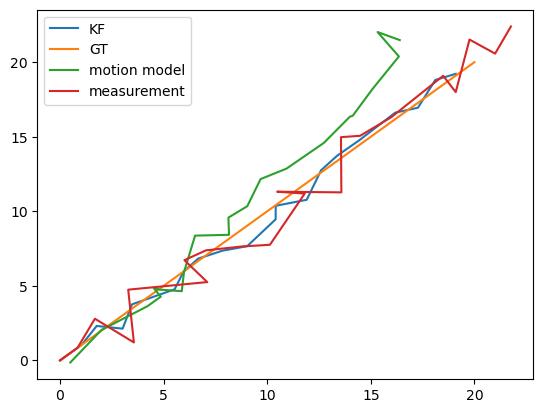

In [6]:
X_KF, covariance = KalmanFilter(num_steps, initial_pos_belief_mean, initial_pos_belief_covariance, motion_vel, MEASUREMENT, A, B, Q, H, R)

# ensuring lengths are same
assert len(X_KF) == len(X_GT) == len(X_MODEL) == len(MEASUREMENT)

plt.plot(X_KF[:, 0], X_KF[:, 1], label='KF')
plt.plot(X_GT[:, 0], X_GT[:, 1], label='GT')
plt.plot(X_MODEL[:, 0], X_MODEL[:, 1], label='motion model')
plt.plot(MEASUREMENT[:, 0], MEASUREMENT[:, 1], label='measurement')
plt.legend()
plt.show()

In [7]:
def calculate_RMSE(v1, v2):
    assert len(v1) == len(v2)
    return np.sqrt(np.sum((v1-v2)**2) / len(v1))

print('RMSE between GT and KF: ', calculate_RMSE(X_GT, X_KF).round(3))
print('RMSE between GT and MOTION MODEL: ', calculate_RMSE(X_GT, X_MODEL).round(3))
print('RMSE between GT and MEASUREMENT: ', calculate_RMSE(X_GT, MEASUREMENT).round(3))

RMSE between GT and KF:  1.705
RMSE between GT and MOTION MODEL:  2.193
RMSE between GT and MEASUREMENT:  1.978


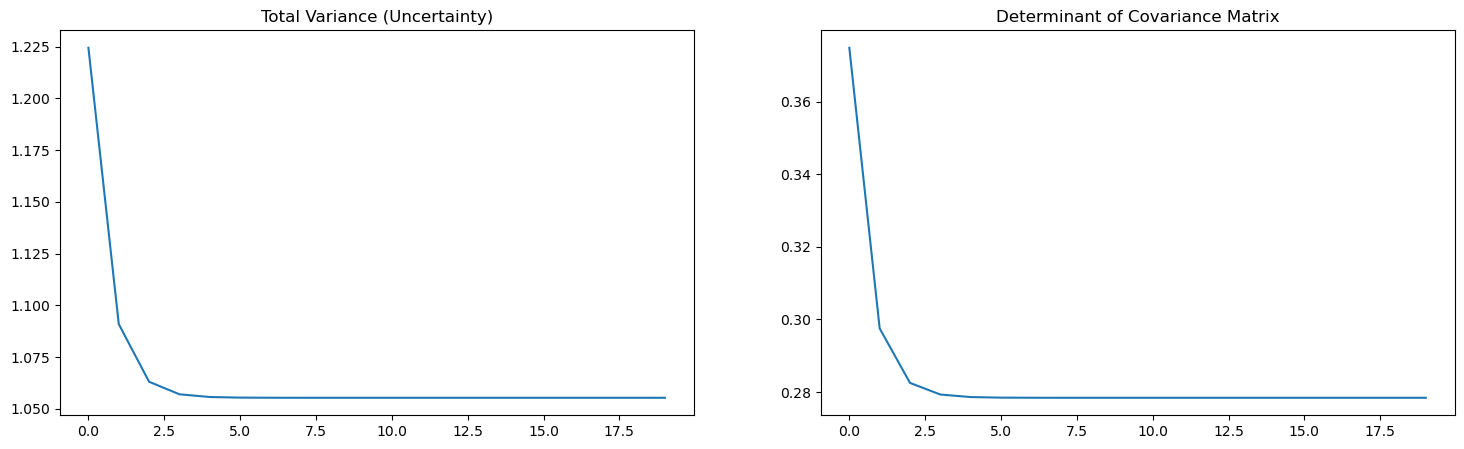

In [8]:
plt.figure(figsize=(18, 5))
total_variances = [np.trace(covariance[i]) for i in range(num_steps)]
determinants = [np.linalg.det(covariance[i]) for i in range(num_steps)]

plt.subplot(121)
plt.plot(total_variances)
plt.title('Total Variance (Uncertainty)')
plt.subplot(122)
plt.plot(determinants)
plt.title('Determinant of Covariance Matrix')
plt.show()